## Imports

In [6]:
import numpy as np
import matplotlib.pyplot as plt

!pip install faiss-cpu -q
import faiss

In [7]:
def find_hash_bit(point, hyperplane):
    return np.dot(point, hyperplane[:-1]) > - hyperplane[-1]

In [8]:
class LSH:
    def __init__(self, num_hash_tables = 75):
        self.num_hash_tables = num_hash_tables
        self.hash_tables = [{} for _ in range(num_hash_tables)]
        self.k = None

    def fit(self, datapoints, k):
        self.k = k
        self.datapoints = datapoints
        self.num_points, self.dim = datapoints.shape
        # Randomly select hyperplanes
        self.hyperplanes = np.random.randn(self.num_hash_tables, self.k, self.dim + 1)

        # Builds up the different hash tables
        for i in range(self.num_hash_tables):
            for j in range(self.num_points):
                hash_code = 0
                for l in range(self.k):
                    # equivalent of maintaining a bit string
                    hash_code = (hash_code << 1) + find_hash_bit(datapoints[j], self.hyperplanes[i, l])

                if hash_code not in self.hash_tables[i]:
                    self.hash_tables[i][hash_code] = []
                self.hash_tables[i][hash_code].append(j)

    def predict(self, query_point, max_search_radius=3):
        if self.k is None:
            raise ValueError('Model not fitted yet! Run fit method first.')

        candidate_counts = {}
        search_radius = 0 # used if the selected region has less than k points

        while len(candidate_counts) < self.k and search_radius <= max_search_radius:
            
            for i in range(self.num_hash_tables):
                # Hashing the query point  
                hash_code = 0
                for l in range(self.k):
                    hash_code = (hash_code << 1) + find_hash_bit(query_point, self.hyperplanes[i, l])
                
                # Searching within given radius
                for offset in range(-search_radius, search_radius + 1):
                    adjusted_hash_code = hash_code + offset
                    if adjusted_hash_code in self.hash_tables[i]:
                        for candidate in self.hash_tables[i][adjusted_hash_code]:
                            if candidate in candidate_counts:
                                candidate_counts[candidate] += 1
                            else:
                                candidate_counts[candidate] = 1
            search_radius += 1  # Increase search radius

        if candidate_counts:
            sorted_candidates = sorted(candidate_counts.items(), key=lambda x: -x[1])[:k]
            return [point for point, _ in sorted_candidates]
        else:
            return []

In [9]:
# Random datapoint selection
num_points = 200
num_features = 2

datapoints = np.random.randint(0, 150, size = (num_points, num_features))
k = 7
dim = 2
n_bits = 75
query_point = np.array([100, -100])

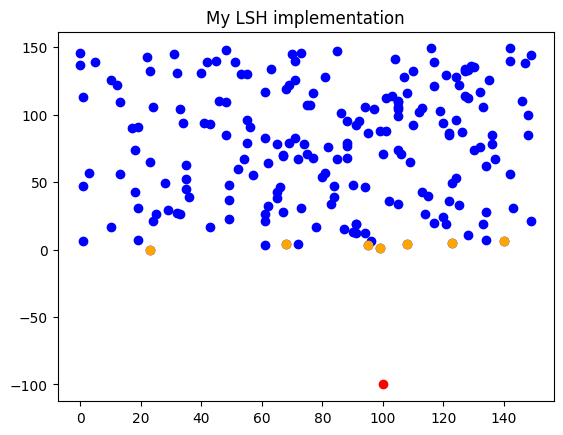

In [10]:
lsh = LSH(num_hash_tables = n_bits)
lsh.fit(datapoints, k)
lis = lsh.predict(query_point)

plt.scatter(datapoints[:, 0], datapoints[:, 1], color = 'blue')
plt.scatter(datapoints[lis[:k], 0], datapoints[lis[:k], 1], color = 'orange')
plt.scatter(100, -100, color = 'red')
plt.title("My LSH implementation")
plt.show()

sklearn has depreceated their implimentation of Locally Sensitve Hashing and faiss is a library that still offers it

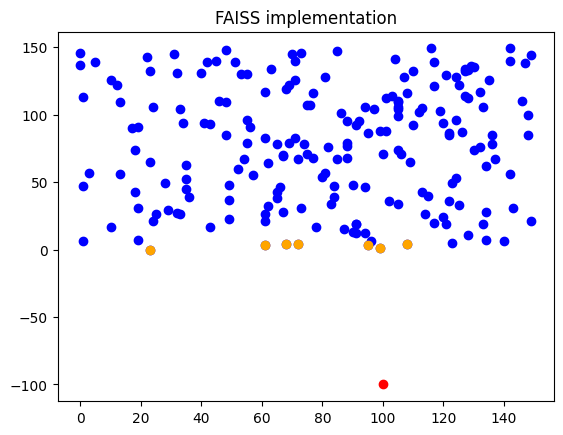

In [11]:
index = faiss.IndexLSH(dim, n_bits)
index.add(datapoints)
_, nearest_neighbors = index.search(query_point.reshape(1, -1), k)

# Plotting the resuls
plt.scatter(datapoints[:, 0], datapoints[:, 1], color = 'blue')
plt.scatter(datapoints[nearest_neighbors[0], 0], datapoints[nearest_neighbors[0], 1], color='orange')
plt.scatter(query_point[0], query_point[1], color = 'red')
plt.title("FAISS implementation")
plt.show()